In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from spconv.pytorch.utils import PointToVoxel

from implicitmorph import utils, dataio, argument_parser

/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/functional.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  _TORCH_CUSTOM_FWD = amp.custom_fwd(cast_inputs=torch.float16)
/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/functional.py:97: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/functional.py:163: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/function

In [2]:
def voxelize_in_model(feats, batch_ids, batch_size, voxel_size, use_coords=True, use_feats=False, max_num_points_per_voxel=3, epsilon=1):
    voxel_coords, voxel_feats, v2p_maps = [], [], []
    total_len_voxels = 0
    for i in range(batch_size):
        feats_one_element = feats[batch_ids == i]
        min_range = torch.min(feats_one_element[:, :3], dim=0).values
        max_range = torch.max(feats_one_element[:, :3], dim=0).values + epsilon

        voxelizer = PointToVoxel(
            vsize_xyz=[voxel_size, voxel_size, voxel_size],
            coors_range_xyz=min_range.tolist() + max_range.tolist(),
            num_point_features=feats.shape[1],
            max_num_voxels=len(feats),
            max_num_points_per_voxel=max_num_points_per_voxel,
            device=feats.device)
        voxel_feat, voxel_coord, _, v2p_map = voxelizer.generate_voxel_with_id(feats_one_element)
        assert torch.sum(v2p_map == -1) == 0
        voxel_coord[:, [0, 2]] = voxel_coord[:, [2, 0]]
        voxel_coord = torch.cat((torch.ones((len(voxel_coord), 1), device=feats.device)*i, voxel_coord), dim=1)

        # get mean feature of voxel
        zero_rows = torch.sum(voxel_feat == 0, dim=2) == voxel_feat.shape[2]
        voxel_feat[zero_rows] = float("nan")
        voxel_feat = torch.nanmean(voxel_feat, dim=1)
        if not use_coords:
            voxel_feat[:, :3] = torch.ones_like(voxel_feat[:, :3])
        if not use_feats:
            voxel_feat[:, 3:] = torch.ones_like(voxel_feat[:, 3:])
        voxel_feat = torch.hstack([voxel_feat[:, 3:], voxel_feat[:, :3]])

        voxel_coords.append(voxel_coord)
        voxel_feats.append(voxel_feat)
        v2p_maps.append(v2p_map + total_len_voxels)
        total_len_voxels += len(voxel_coord)
    voxel_coords = torch.cat(voxel_coords, dim=0)
    voxel_feats = torch.cat(voxel_feats, dim=0)
    v2p_maps = torch.cat(v2p_maps, dim=0)
    spatial_shape = voxel_coords.max(dim=0).values + 1

    return voxel_feats, voxel_coords, v2p_maps, spatial_shape[1:]

In [3]:
def transform_input(pointclouds):
    bs, N, _ = pointclouds.shape
    coords = pointclouds.reshape(-1,3)
    feats = torch.randn(N*bs,3)
    batch_ids = torch.arange(bs).repeat_interleave(int(N))
    return coords, feats, batch_ids, bs

In [4]:
def voxelize(data, voxel_size):
    coords, feats, batch_ids, batch_size = transform_input(data)
    voxel_feats, voxel_coords, v2p_maps, spatial_shape = voxelize_in_model(torch.hstack([coords, feats]), batch_ids, batch_size, voxel_size)
    return voxel_coords

In [5]:
id_list_path = '/scratch-emmy/usr/nimpede1/pcs_v7_volume_rotation/labels_splits/train.npy'
experiment_folder = 'voxel_neuron_morph/logs/test'
id_list = np.load(id_list_path, allow_pickle=True)
opt = utils.load_config(experiment_folder)
opt.use_amp=argument_parser.t_or_f(opt.use_amp)
opt.normalization_per_shape = argument_parser.t_or_f(opt.normalization_per_shape)
opt.curriculum_learning = argument_parser.t_or_f(opt.curriculum_learning)
opt.should_early_stop = argument_parser.t_or_f(opt.should_early_stop)

opt.bce_loss = argument_parser.t_or_f(opt.bce_loss)
opt.occ_boundary_loss = argument_parser.t_or_f(opt.occ_boundary_loss)
opt.inter_loss = argument_parser.t_or_f(opt.inter_loss)
opt.normals_loss = argument_parser.t_or_f(opt.normals_loss)
opt.grad_loss = argument_parser.t_or_f(opt.grad_loss)
opt.l1_loss = argument_parser.t_or_f(opt.l1_loss)
opt.latent_kld_loss = argument_parser.t_or_f(opt.latent_kld_loss)
opt.latent_kld_prior_loss = argument_parser.t_or_f(opt.latent_kld_prior_loss)
opt.latent_norm_loss = argument_parser.t_or_f(opt.latent_norm_loss)

opt.n_shapes = int(opt.n_shapes)
opt.num_epochs = int(opt.num_epochs)
opt.lr = float(opt.lr)
opt.batch_size = int(opt.batch_size)
opt.num_hidden_layers = int(opt.num_hidden_layers)
opt.hidden_features = int(opt.hidden_features)
opt.shape_dim = int(opt.shape_dim)
opt.on_surface_points = int(opt.on_surface_points)
opt.resolution = int(opt.resolution)

In [6]:
dataset = dataio.MicronsMinnieFastGPU(pointcloud_path=opt.pointcloud_path, all_segment_splits=id_list, n_shapes=1, on_surface_points=int(opt.on_surface_points), uniform_points=int(opt.uniform_points), bb_points=int(opt.bb_points), perturbed_points=int(opt.perturbed_points), normalization_per_shape=opt.normalization_per_shape, centering=opt.centering, rank=0)

on surface: 5000 uniform: 2000 bb: 2000 perturbed: 1000 total: 10000 encoder: 100000
0 [0]
[INFO] load all shapes
Achtung nicht preprocessed
[INFO] all shapes loaded


In [7]:
data = next(iter(dataset))
data.keys()

dict_keys(['coords', 'pointcloud', 'neuron_id', 'occupancy', 'normals'])

In [8]:
pointcloud = data['pointcloud'].detach().cpu()#.numpy()
pointcloud = pointcloud[None, :]

In [9]:
import torch

def plot(data):
    # Convert the input numpy array to a torch tensor if necessary
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    
    # Ensure the tensor is of the correct type (float or int as per your requirements)
    data = data.float()  # or .int(), depending on your data type

    # 1. Rotate the voxel grid by 90 degrees around the y-axis
    voxels_rotated = torch.rot90(data, k=1, dims=(1, 2))  # Swapping the y and z axes

    # 2. Flip along the z-axis
    voxels_flipped = torch.flip(voxels_rotated, dims=[2])  # Flip along the z-axis
    
    # Plot the rotated and flipped voxel grid
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.voxels(voxels_flipped.numpy(), facecolors='blue', edgecolor='k')  # Convert back to numpy for plotting
    plt.show()


In [10]:
def to_dense(voxel_coords):
    data = voxel_coords[:,1:].numpy().astype(int)
    arr = np.zeros((np.max(data, axis=0))+1)
    arr[data[:,0], data[:,1], data[:,2]] = 1
    return arr.astype(bool)

Point cloud, subsampled to n=100000 points.


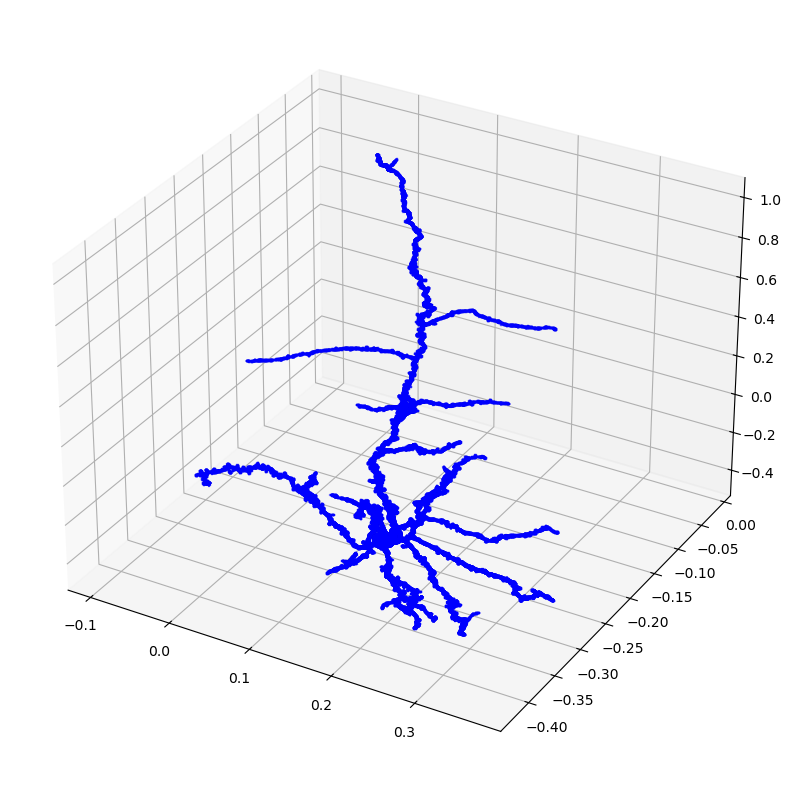

In [11]:
print(f'Point cloud, subsampled to n={len(pointcloud[0])} points.')

# Convert pointcloud to a 3D tensor for rotation and flipping
# Point cloud is assumed to be in shape [1, num_points, 3] (x, y, z)

# 1. Rotate the point cloud by 90 degrees around the y-axis (similar to torch.rot90 for voxels)
pointcloud_rotated = pointcloud.clone()
pointcloud_rotated[:, :, [1, 2]] = pointcloud[:, :, [2, 1]]  # Swapping y and z coordinates simulates the 90° rotation

# 2. Flip along the z-axis (similar to torch.flip along dims=[2] for voxels)
pointcloud_flipped = pointcloud_rotated
pointcloud_flipped[:, :, 2] = -pointcloud_rotated[:, :, 2]
pointcloud_flipped[:, :, 1] = -pointcloud_flipped[:, :, 1]

# Plot the rotated and flipped point cloud
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
data = pointcloud_flipped[0]  # Extract the corrected point cloud
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=1, marker='s')
plt.show()

torch.Size([49, 4])
Voxelized with voxel_size=0.1 to n=49 voxels.


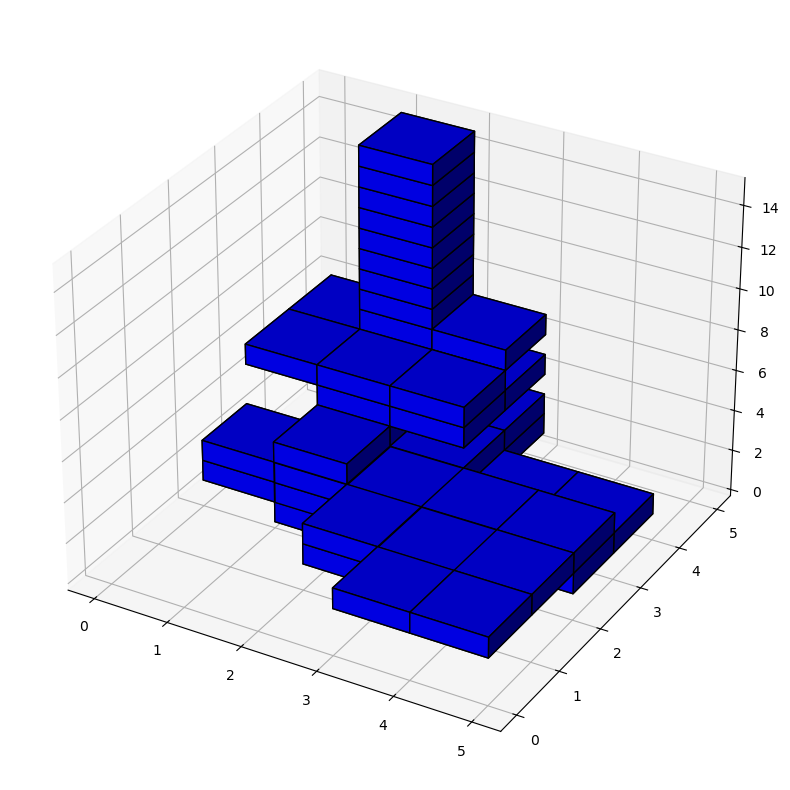

In [12]:
grid_size = 20
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(voxel_pc.shape)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

torch.Size([245, 4])
Voxelized with voxel_size=0.03125 to n=245 voxels.


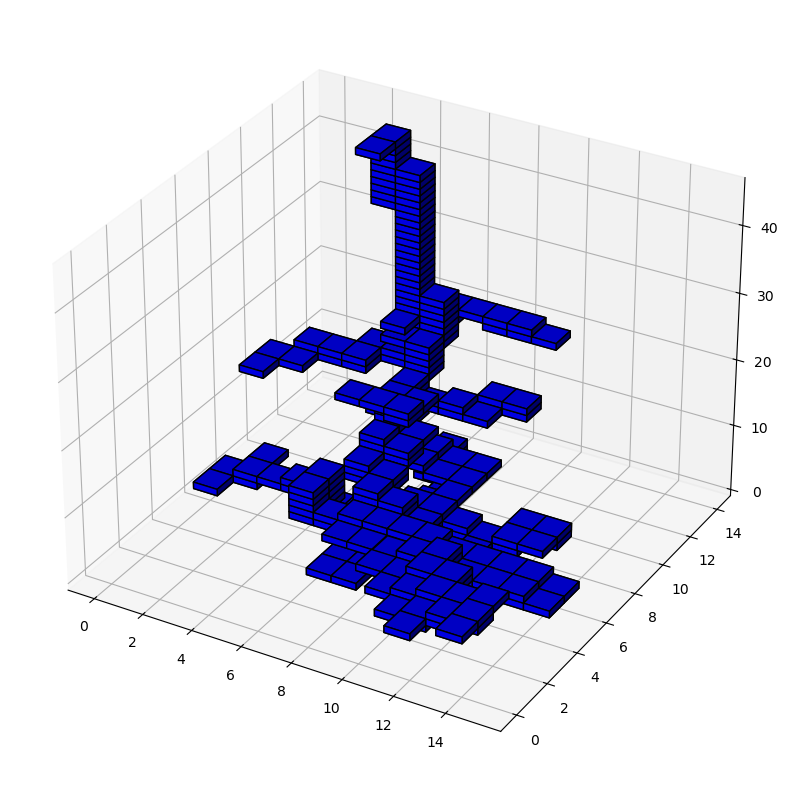

In [13]:
grid_size = 64
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(voxel_pc.shape)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

torch.Size([610, 4])
Voxelized with voxel_size=0.015625 to n=610 voxels.


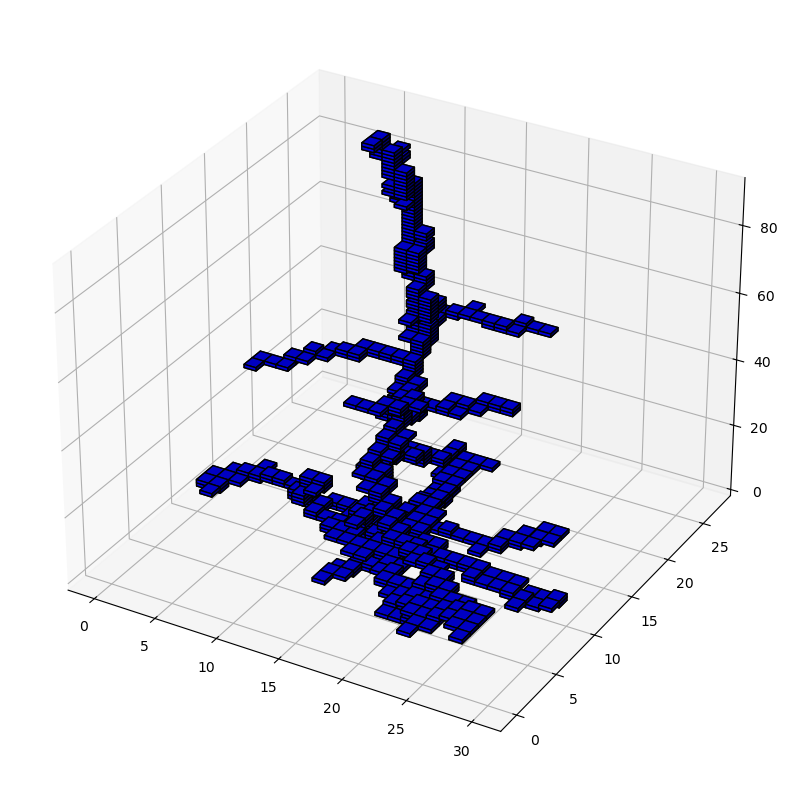

In [14]:
grid_size = 128
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(voxel_pc.shape)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

torch.Size([1070, 4])
Voxelized with voxel_size=0.01 to n=1070 voxels.


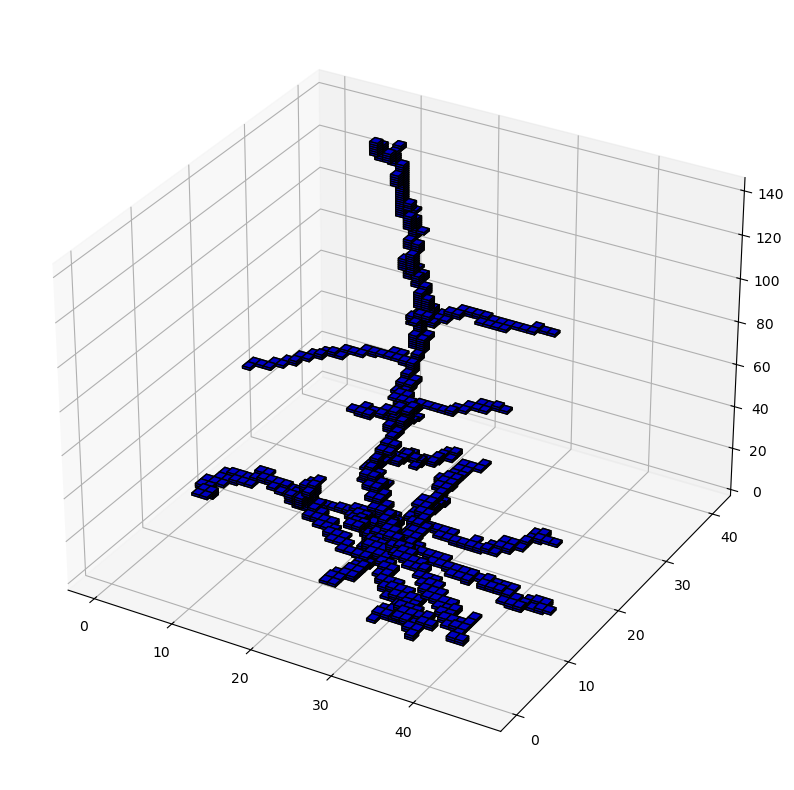

In [15]:
grid_size = 200
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(voxel_pc.shape)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

torch.Size([2777, 4])
Voxelized with voxel_size=0.005 to n=2777 voxels.


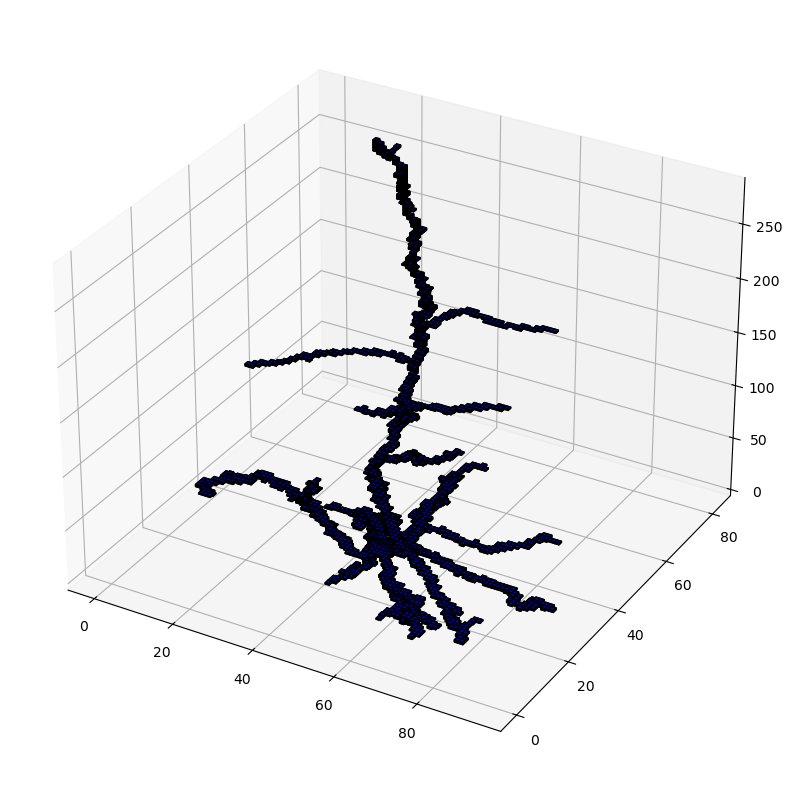

In [16]:
grid_size = 400
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(voxel_pc.shape)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

Voxelized with voxel_size=0.0025 to n=7464 voxels.


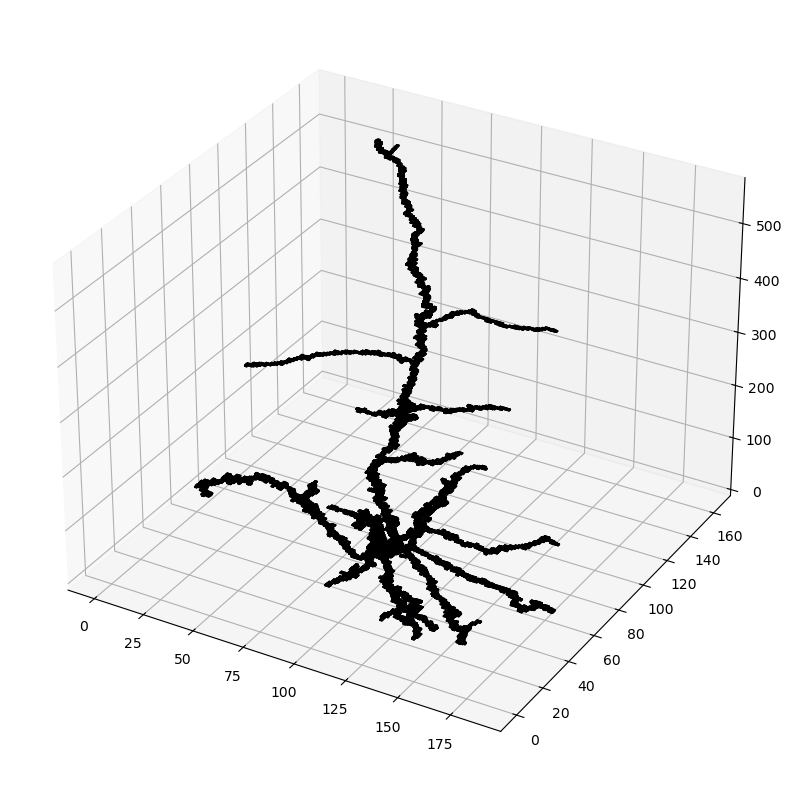

In [17]:
grid_size = 800
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

Voxelized with voxel_size=0.002 to n=10246 voxels.


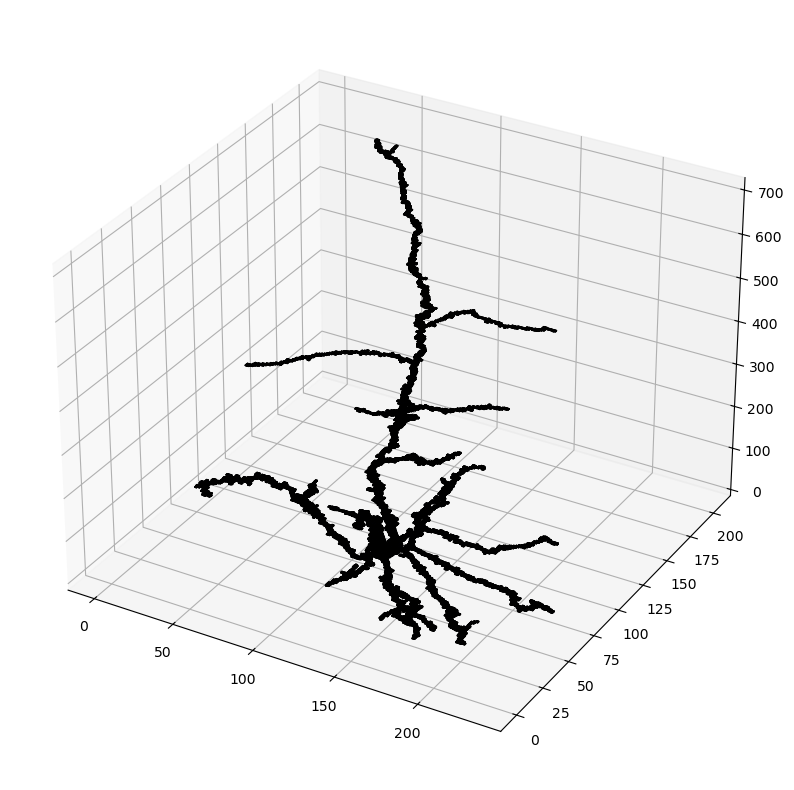

In [18]:
grid_size = 1000
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
plot(to_dense(voxel_pc))

## Zoomed in plot to see synapses

Voxelized with voxel_size=0.03125 to n=243 voxels.


(0.0, 10.0)

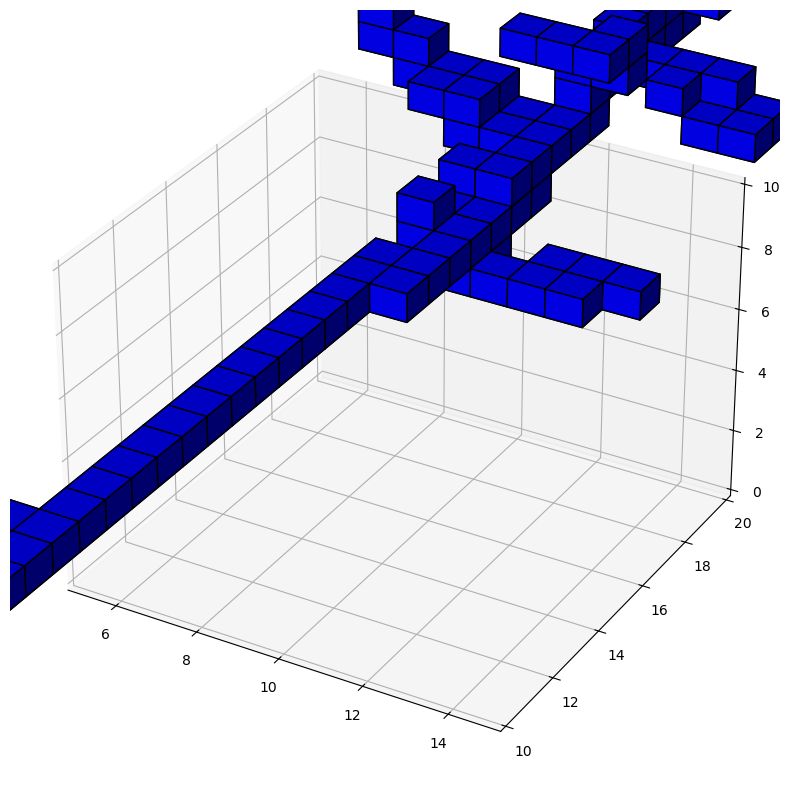

In [20]:
grid_size = 64
voxel_size = 2 / grid_size
voxel_pc = voxelize(pointcloud, voxel_size)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
data = to_dense(voxel_pc)*voxel_size
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
ax.voxels(data, facecolors='blue', edgecolor='k')
ax.set_xlim(5, 15)
ax.set_ylim(10, 20)
ax.set_zlim(0, 10)

Voxelized with voxel_size=0.005 to n=2563 voxels.


(0.0, 20.0)

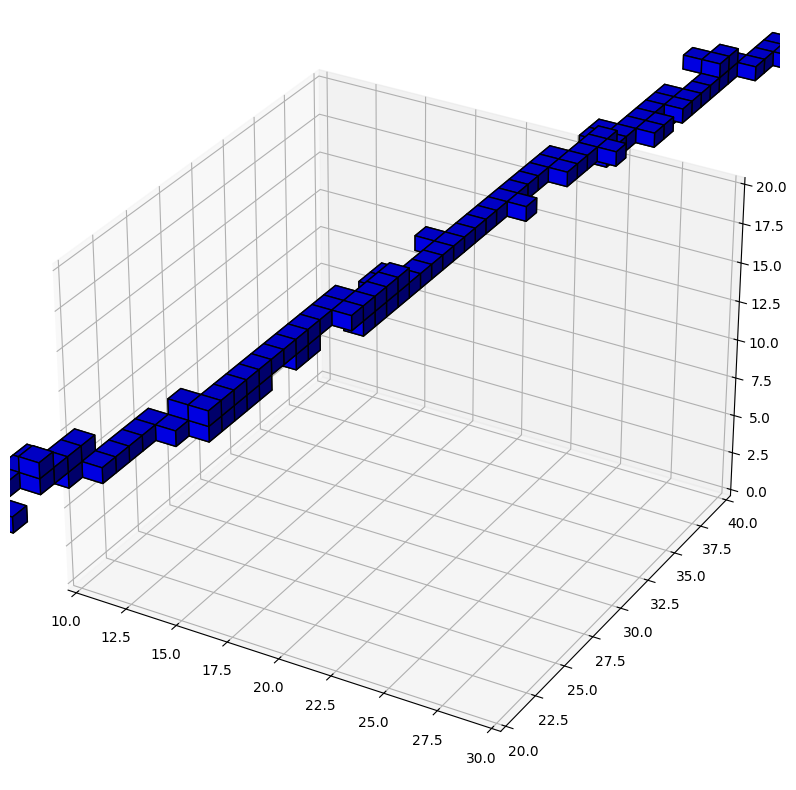

In [32]:
voxel_size = 0.005
voxel_pc = voxelize(pointcloud, voxel_size)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
data = to_dense(voxel_pc)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
ax.voxels(data, facecolors='blue', edgecolor='k')
scale = 0.01/voxel_size
ax.set_xlim(5*scale, 15*scale)
ax.set_ylim(10*scale, 20*scale)
ax.set_zlim(0*scale, 10*scale)

Voxelized with voxel_size=0.0025 to n=6842 voxels.


(0.0, 40.0)

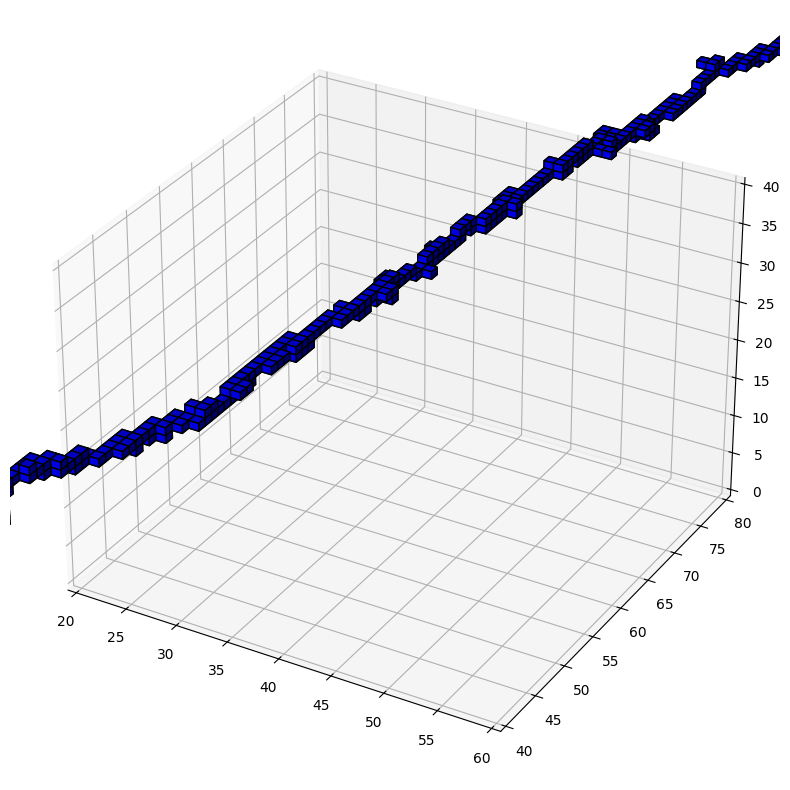

In [33]:
voxel_size = 0.0025
voxel_pc = voxelize(pointcloud, voxel_size)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
data = to_dense(voxel_pc)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
ax.voxels(data, facecolors='blue', edgecolor='k')
scale = 0.01/voxel_size
ax.set_xlim(5*scale, 15*scale)
ax.set_ylim(10*scale, 20*scale)
ax.set_zlim(0*scale, 10*scale)

Voxelized with voxel_size=0.002 to n=9350 voxels.


(0.0, 50.0)

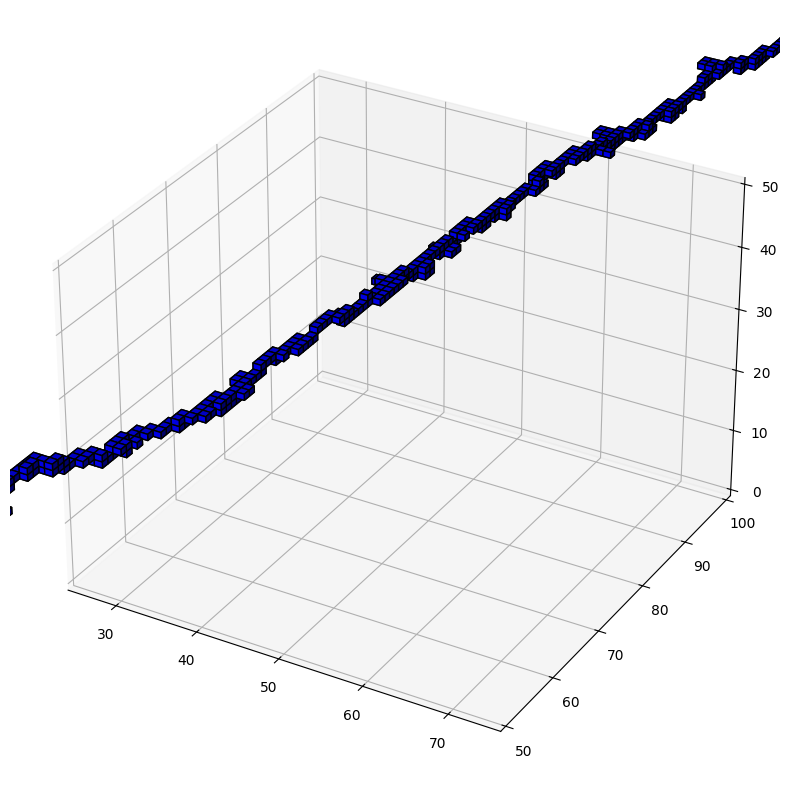

In [34]:
voxel_size = 0.002
voxel_pc = voxelize(pointcloud, voxel_size)
print(f'Voxelized with {voxel_size=} to n={len(voxel_pc)} voxels.')
data = to_dense(voxel_pc)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
ax.voxels(data, facecolors='blue', edgecolor='k')
scale = 0.01/voxel_size
ax.set_xlim(5*scale, 15*scale)
ax.set_ylim(10*scale, 20*scale)
ax.set_zlim(0*scale, 10*scale)